In [1]:
# Import necessary libraries

import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import when

from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.feature import OneHotEncoder, VectorSlicer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from sklearn.metrics import f1_score, recall_score, precision_score

In [2]:
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [3]:
path = "user_data_agg.json"
df = spark.read.json(path)

In [4]:
# Create pipeline for data processing by Spark

categoricalColumns = ["gender", "region"]
numericCols = ['avg_mins_on_date',
 'avg_nextsong_per_day',
 'avg_nextsong_per_month',
 'avg_submit_downgrade_per_day',
 'avg_submit_downgrade_per_month',
 'avg_submit_upgrade_per_day',
 'avg_submit_upgrade_per_month',
 'avg_sum_about_per_day',
 'avg_sum_about_per_month',
 'avg_sum_add_friend_per_day',
 'avg_sum_add_friend_per_month',
 'avg_sum_add_playlist_per_day',
 'avg_sum_add_playlist_per_month',
 'avg_sum_downgrade_per_day',
 'avg_sum_downgrade_per_month',
 'avg_sum_error_per_day',
 'avg_sum_error_per_month',
 'avg_sum_help_per_day',
 'avg_sum_help_per_month',
 'avg_sum_home_month',
 'avg_sum_home_per_day',
 'avg_sum_logout_per_day',
 'avg_sum_logout_per_month',
 'avg_sum_roll_advert_per_day',
 'avg_sum_roll_advert_per_month',
 'avg_sum_save_settings_per_day',
 'avg_sum_save_settings_per_month',
 'avg_sum_settings_per_day',
 'avg_sum_settings_per_month',
 'avg_sum_thumbs_down_per_day',
 'avg_sum_thumbs_down_per_month',
 'avg_sum_thumbs_up_per_day',
 'avg_sum_thumbs_up_per_month',
 'avg_sum_upgrade_per_day',
 'avg_sum_upgrade_per_month',
 'avg_visits_next_songs',
 'paid_pct',
 'pct_total_pos_engagement',
              ]
stages = [] # stages in Pipeline

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "classVec")
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol="churned", outputCol="label")
stages += [label_stringIdx]

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features")
stages += [assembler]

scaler = MinMaxScaler(inputCol="vectorized_features", outputCol="features")
stages += [scaler]

In [5]:
# Split data into train and test. Use pipeline to process the data for analysis.

cols = numericCols + categoricalColumns + ['churned']
train, test = df[cols].randomSplit([0.8, 0.2], seed=1973)

partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(train)
train_df = pipelineModel.transform(train)

selectedCols = ['label', 'features'] + cols
train_df = train_df.select(selectedCols)

test_df = pipelineModel.transform(test)

In [6]:
def get_metrics(predictions):
    """Calculate metrics"""
    selected = predictions.toPandas()
    f1 = f1_score(selected.label, selected.prediction)
    recall = recall_score(selected.label, selected.prediction)
    precision = precision_score(selected.label, selected.prediction)

    area_under_PR = evaluator.evaluate(predictions)
    
    return f1, recall, precision, area_under_PR

### 1. Initial Random Forest model for feature selection

Sort feature importances [https://people.stat.sc.edu/haigang/improvement.html]. These will be used to select the more important features.

In [7]:
evaluator = BinaryClassificationEvaluator(metricName="areaUnderPR") 
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=1973)
rf_model = rf.fit(train_df)

In [8]:
importance_list = pd.Series(rf_model.featureImportances.values)
sorted_imp = importance_list.sort_values(ascending= False)

Use the feature importance values to select features for the training set. Select a cut-off value that maximizes the area under the precision-recall curve for the modified training sets. Depending on the cut-off chosen each training set will have different number of features

In [9]:
cut_offs = np.arange(0.010, 0.080, 0.005) 
 
train_pr = []

for c in cut_offs:

    kept = list((sorted_imp[sorted_imp > c]).index)
    vector_slicer = VectorSlicer(inputCol= "features", indices= kept, outputCol="feature_subset")
    with_selected_feature = vector_slicer.transform(train_df)

    rf_modified = RandomForestClassifier(featuresCol="feature_subset", seed=1973)
    
    rf_model = rf_modified.fit(with_selected_feature)
    predictions_modified = rf_model.transform(with_selected_feature)
    
    evaluator_modified = BinaryClassificationEvaluator(metricName="areaUnderPR")
    train_pr.append(evaluator_modified.evaluate(predictions_modified))


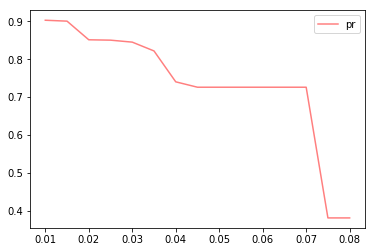

In [10]:
#Plot areaUnderPR vs cut-offs
plt.plot(cut_offs, train_pr, alpha=0.5, color='r', label="pr")

plt.legend()
plt.show();

In [11]:
#Index of cut-off at which area under PR is maximized
max_idx = np.where((np.round(train_pr, 10) == (np.round(max(train_pr), 10))))
print(f"Number of variables selected: {len(sorted_imp[sorted_imp > cut_offs[max_idx[0][0]]])}")

Number of variables selected: 31


In [12]:
#Keep reduced set of features in train, test
kept = list((sorted_imp[sorted_imp > cut_offs[max_idx[0][0]]]).index)
vector_slicer = VectorSlicer(inputCol= "features", indices= kept, outputCol="feature_subset")
train_df_reduced = vector_slicer.transform(train_df)

test_df_reduced = vector_slicer.transform(test_df)

In [13]:
#Set area under PR as the metric. 
evaluator_modified = BinaryClassificationEvaluator(metricName="areaUnderPR")

### 2. Random Forest

Fit the random forest model with reduced set of variables. 

In [14]:
#Fit a random forests model with default settings
rf = RandomForestClassifier(featuresCol="feature_subset", seed=1973)
rf_default = rf.fit(train_df_reduced)

# Make predictions on all train data
predictions = rf_default.transform(train_df_reduced)

In [15]:
print(f"Feature subset strategy: {rf_default._java_obj.getFeatureSubsetStrategy()}")
print(f"Feature subsampling rate: {rf_default._java_obj.getSubsamplingRate()}")
print(f"Number of trees: {rf_default._java_obj.getNumTrees()}")
print(f"Max depth: {rf_default._java_obj.getMaxDepth()}")

Feature subset strategy: auto
Feature subsampling rate: 1.0
Number of trees: 20
Max depth: 5


In [16]:
f1, recall, precision, area_under_PR = get_metrics(predictions)
print(f'F1-Score: {f1:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, Area under PR: {area_under_PR:.3f}')

F1-Score: 0.607, Recall: 0.436, Precision: 1.000, Area under PR: 0.903


#### Grid search: 
Use grid search with cross-validation to find best model parameters

In [17]:
rf_modified = RandomForestClassifier(featuresCol="feature_subset", seed=1973)

paramGrid = (ParamGridBuilder()
             .addGrid(rf_modified.featureSubsetStrategy, ['4', '6', '8'])
             .addGrid(rf_modified.subsamplingRate, [0.8, 1])
             .addGrid(rf_modified.maxDepth, [5, 8])
             .build())

cv = CrossValidator(estimator=rf_modified, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator_modified, numFolds=5, seed=1973)
cv_Model = cv.fit(train_df_reduced)

best_model = cv_Model.bestModel

In [18]:
fss = best_model._java_obj.getFeatureSubsetStrategy()
ssr = best_model._java_obj.getSubsamplingRate()
num_trees = best_model._java_obj.getNumTrees()
max_depth = best_model._java_obj.getMaxDepth()

In [20]:
#Fit the best model on the entire training set

rf_complete = RandomForestClassifier(featuresCol="feature_subset", subsamplingRate=ssr, maxDepth=max_depth, 
                                     featureSubsetStrategy=fss, seed=1973)
rf_complete_model = rf_complete.fit(train_df_reduced)

# Make predictions on all train data
predictions = rf_complete_model.transform(train_df_reduced)


In [21]:
f1, recall, precision, area_under_PR = get_metrics(predictions)
print(f'F1-Score: {f1:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, Area under PR: {area_under_PR:.3f}')

F1-Score: 0.818, Recall: 0.692, Precision: 1.000, Area under PR: 0.998


### 3. Logistic Regression

In [22]:
#Create weight variable to address the class imbalance in the target
dataset_size = float(train_df.select("label").count())
numPositives = train_df.select("label").where('label == 1').count()
per_ones = (float(numPositives)/float(dataset_size))*100
numNegatives = float(dataset_size - numPositives)
BalancingRatio = numNegatives/dataset_size

In [23]:
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))
print('Balancing ratio {}'.format(BalancingRatio))

The number of ones are 78
Percentage of ones are 22.413793103448278
Balancing ratio 0.7758620689655172


In [24]:
#Add the weights variable to the train set
train_with_weights = train_df_reduced.withColumn("classWeights", 
                                                               when(train_df.label == 1, 
                                                                    BalancingRatio).otherwise(1 - BalancingRatio))

Fit a logistic regression model with the reduced set of variables. Use grid search with cross-validation to find best model parameters

In [25]:
lr = LogisticRegression(labelCol="label", featuresCol="feature_subset", weightCol="classWeights")

paramGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0.01, 0.5, 2.0])
            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
            .addGrid(lr.maxIter, [10, 15])
            .addGrid(lr.threshold, [0.4, 0.5, 0.6])
            .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator_modified, numFolds=5, seed=1973)
cv_Model = cv.fit(train_with_weights)
best_model = cv_Model.bestModel


In [26]:
enp = best_model._java_obj.getElasticNetParam()
rp = best_model._java_obj.getRegParam()
max_iter = best_model._java_obj.getMaxIter()
threshold = best_model._java_obj.getThreshold()

In [27]:
#Fit the model with the best parameters on the entire training set
lr_complete = LogisticRegression(labelCol="label", featuresCol="feature_subset", weightCol="classWeights",
                       threshold=threshold, elasticNetParam=enp, regParam=rp, maxIter=max_iter)
lr_complete_model = lr_complete.fit(train_with_weights)

# Make predictions on all train data
predictions = lr_complete_model.transform(train_with_weights)


In [28]:
f1, recall, precision, area_under_PR = get_metrics(predictions)
print(f'F1-Score: {f1:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, Area under PR: {area_under_PR:.3f}')

F1-Score: 0.401, Recall: 0.949, Precision: 0.254, Area under PR: 0.563


### 4. Decision Trees

Fit the decision tree model with reduced set of variables. Use grid search with cross-validation to find best model parameters.

In [29]:
dt = DecisionTreeClassifier(labelCol='label', featuresCol='feature_subset')

paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [4, 5, 6])
             .addGrid(dt.maxBins, [20, 40, 60])
             .build())

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator_modified, numFolds=5, seed=1973)
cv_Model = cv.fit(train_df_reduced)

best_model = cv_Model.bestModel

In [30]:
max_depth = best_model._java_obj.getMaxDepth()
max_bins = best_model._java_obj.getMaxBins()

In [31]:
#Fit the model with the best parameters on the entire training set
dt_complete = DecisionTreeClassifier(labelCol='label', featuresCol='feature_subset', seed=1973,
                                     maxDepth=max_depth, maxBins=max_bins)
dt_complete_model = dt_complete.fit(train_df_reduced)

# Make predictions on all train data
predictions = dt_complete_model.transform(train_df_reduced)

In [32]:
f1, recall, precision, area_under_PR = get_metrics(predictions)
print(f'F1-Score: {f1:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, Area under PR: {area_under_PR:.3f}')

F1-Score: 0.791, Recall: 0.654, Precision: 1.000, Area under PR: 0.321


### Fit best model to test data

In [60]:
evaluator_modified = BinaryClassificationEvaluator(metricName="areaUnderPR")

# Make predictions on test data
predictions = lr_complete_model.transform(test_df_reduced)

In [61]:
#lr
f1, recall, precision, area_under_PR = get_metrics(predictions)
print(f'F1-Score: {f1:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, Area under PR: {area_under_PR:.3f}')

F1-Score: 0.340, Recall: 0.900, Precision: 0.209, Area under PR: 0.378


We use the logistic model despite it having a lower area under pr value compared to the random forest model. The latter appears to be overfitting. We still get a rather poor f1-score but a high recall. We are able to capture most of the users that churned but at the cost of having false positives which lowers precision.

**References:**
- https://people.stat.sc.edu/haigang/improvement.html
- https://datascience.stackexchange.com/questions/13960/how-to-choose-a-classifier-after-cross-validation
- https://stats.stackexchange.com/questions/2306/feature-selection-for-final-model-when-performing-cross-validation-in-machine
- https://medium.com/swlh/logistic-regression-with-pyspark-60295d41221
- https://towardsdatascience.com/predict-customer-churn-using-pyspark-machine-learning-519e866449b5
- https://docs.databricks.com/_static/notebooks/binary-classification.html
- https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
- https://stackoverflow.com/questions/53528481/feature-selection-in-pyspark